In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import numpy as np
from PIL import Image





In [44]:
def normalize_only(img):
    img = np.array(img).astype(np.float32) / 255.0
    img = (img - 0.5) / 0.5
    return torch.from_numpy(img).unsqueeze(0)


In [46]:
# --- 2. Load Custom Digits for Training ---
def ProjectDataLoader(path='./handpicked', transform=None):
    images, labels = [], []
    for filename in os.listdir(path):
        if filename.endswith('.png'):
            label = int(filename.split('-')[0])
            img_path = os.path.join(path, filename)
            img = Image.open(img_path).convert('L').resize((28, 28))
            if transform:
                img = transform(img)
            else:
                img = transforms.ToTensor()(img)
            images.append(img)
            labels.append(label)
    return torch.stack(images), torch.tensor(labels).long().squeeze()

custom_batch, custom_labels_tensor = ProjectDataLoader('./handpicked', transform=normalize_only)
custom_dataset = TensorDataset(custom_batch, custom_labels_tensor)
trainloader = DataLoader(custom_dataset, batch_size=16, shuffle=True)

In [48]:

from torchvision import transforms

# Apply only Normalize
class NumpyNormalize:
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        # Convert to numpy if it's not already
        img = np.array(img).astype(np.float32)
        # Normalize [0, 255] to [0, 1] → then to [-1, 1]
        img = img / 255.0
        img = (img - self.mean) / self.std
        return torch.from_numpy(img).unsqueeze(0)  # shape: [1, 28, 28]

# Define the normalization-only transform
normalize_only = NumpyNormalize()

# Load MNIST with only normalization
trainset = datasets.MNIST(root='./MNIST_data', download=True, train=True, transform=normalize_only)
testset = datasets.MNIST(root='./MNIST_data', download=True, train=False, transform=normalize_only)

print("MNIST datasets loaded with normalization only (no ToTensor).")


MNIST datasets loaded with normalization only (no ToTensor).


In [50]:
# Define model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
model = MLP()


Epoch 1 Loss: 2.3175
Epoch 2 Loss: 2.2569
Epoch 3 Loss: 2.1533
Epoch 4 Loss: 2.0700
Epoch 5 Loss: 1.9681
Epoch 6 Loss: 1.8809
Epoch 7 Loss: 1.7744
Epoch 8 Loss: 1.6835
Epoch 9 Loss: 1.5614
Epoch 10 Loss: 1.6079
Epoch 11 Loss: 1.4749
Epoch 12 Loss: 1.4565
Epoch 13 Loss: 1.3044
Epoch 14 Loss: 1.2269
Epoch 15 Loss: 1.2504
Epoch 16 Loss: 1.1767
Epoch 17 Loss: 1.1651
Epoch 18 Loss: 1.0664
Epoch 19 Loss: 0.9580
Epoch 20 Loss: 0.9402
Epoch 21 Loss: 0.9639
Epoch 22 Loss: 0.8965
Epoch 23 Loss: 0.9500
Epoch 24 Loss: 0.8758
Epoch 25 Loss: 0.7258
Epoch 26 Loss: 0.7577
Epoch 27 Loss: 0.7027
Epoch 28 Loss: 0.7252
Epoch 29 Loss: 0.7591
Epoch 30 Loss: 0.9154
Epoch 31 Loss: 0.6589
Epoch 32 Loss: 0.5561
Epoch 33 Loss: 0.6328
Epoch 34 Loss: 0.6460
Epoch 35 Loss: 0.6095
Epoch 36 Loss: 0.6010
Epoch 37 Loss: 0.4879
Epoch 38 Loss: 0.6223
Epoch 39 Loss: 0.7091
Epoch 40 Loss: 0.4584
Epoch 41 Loss: 0.4026
Epoch 42 Loss: 0.3896
Epoch 43 Loss: 0.3854
Epoch 44 Loss: 0.3851
Epoch 45 Loss: 0.4516
Epoch 46 Loss: 0.36

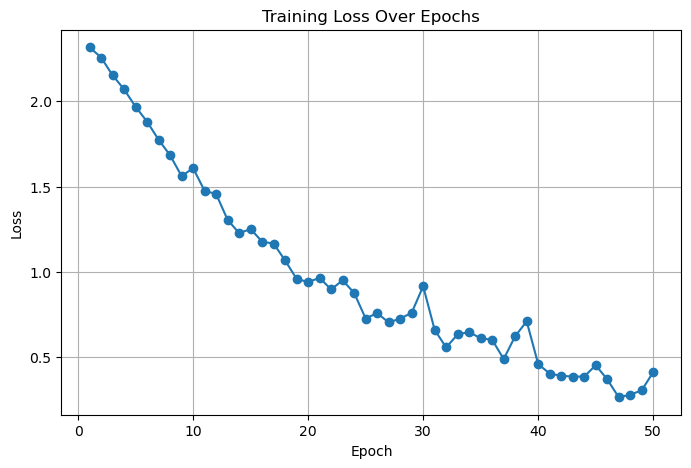

In [52]:
# --- 5. Setup Loss and Optimizer ---
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- 6. Training Loop (No Transformations) ---
loss_history = []
for epoch in range(50):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(trainloader)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

# --- 7. Plot Training Loss ---
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [54]:
# Create test DataLoader from MNIST testset
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)



Accuracy on MNIST test set: 33.35%


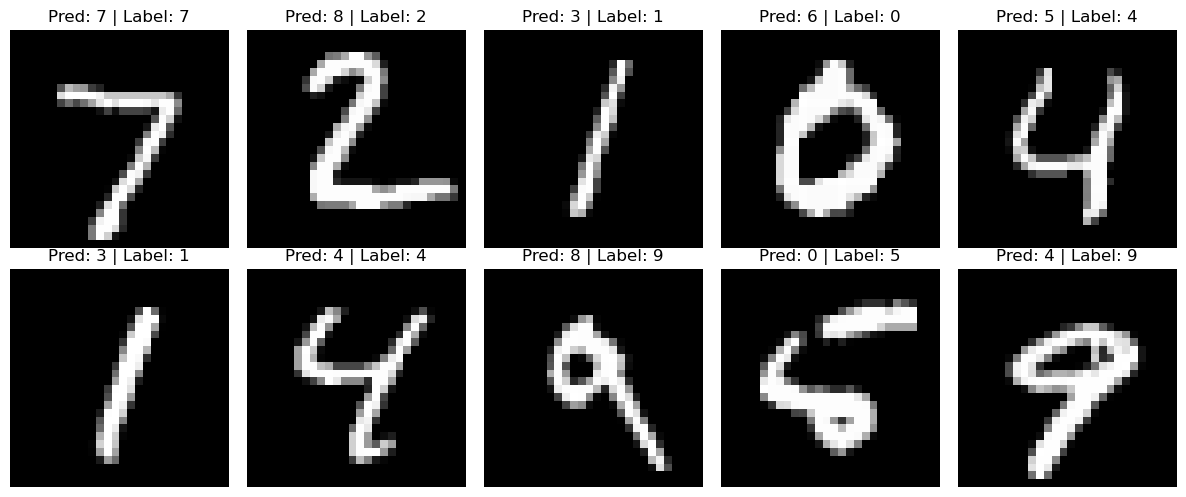

In [56]:
# --- 8. Testing on MNIST Test Set ---
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nAccuracy on MNIST test set: {100 * correct / total:.2f}%")

# --- 9. Visualize a Few Test Predictions ---
def show_mnist_predictions(model, testloader):
    model.eval()
    images, labels = next(iter(testloader))
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axs = plt.subplots(2, 5, figsize=(12, 5))
    for i, ax in enumerate(axs.flat):
        ax.imshow(images[i][0], cmap='gray')
        ax.set_title(f"Pred: {preds[i].item()} | Label: {labels[i].item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_mnist_predictions(model, testloader)